Goal of analysis script is to pull in txt files of annotated USVs and generate summary statistics

Import modules

In [1]:
import pandas as pd
import numpy as np
from tkinter import filedialog
from tkinter import *
import re
import os
from scipy import stats

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Open dialog box and prompt user to select directory containing the data files 

In [3]:
root = Tk()
root.directory = filedialog.askdirectory()
print (root.directory)

C:/Users/Schindler/Documents/Schindler_Lab/Data/USVs/CPA_pair_exp/3x


Create a path name for each data file

In [4]:
path_names = []
files = os.listdir(root.directory)
for file in files: 
        path_names.append(root.directory + "/" + file)

path_names[0]

'C:/Users/Schindler/Documents/Schindler_Lab/Data/USVs/CPA_pair_exp/3x/527.Table.1.selections.base.txt'

Read in and create dataframe of animal parameters (pair: 1 = neutral, 2 = CPA pair; Group: 4 = sham, 5 = blast)

In [5]:
group_file = "C:/Users/Schindler/Documents/Schindler_Lab/Data/Analysis/Excel files/USV/3x_groups.xlsx"
data = pd.read_excel(group_file)
df_mice = pd.DataFrame(data = data)
df_mice = df_mice.drop([15], axis = 0)
df_mice.head()

,Animal,Pair,Group,Notes
0,527,1,5,weak blast; scruffy
1,529,1,5,NaN
2,533,2,5,cage flood am of pair
3,534,2,5,cage flood am of pair
4,535,2,5,cage flood am of pair


Loop through path names to create pandas data table from excel file. Get animal number from path name (animal number is part of file name), use animal number to get group and pair codes from the df_mice table, create array of animal number, group and pair codes the length of the data_table and add each as a column.

In [6]:
data_table = pd.DataFrame()

i = 0

for path in path_names:
    data = pd.read_table(path)
    data_table_int = pd.DataFrame(data = data)
    
    name = re.search("\d\d\d", path).group(0)
    name_mult = [name] * len(data_table_int)
    session = re.search("base|cagepair|CPApair", path).group(0)
    session = [session] * len(data_table_int)
    
    group = df_mice[df_mice['Animal'] == int(name)]['Group'].values[0]
    group = [group] * len(data_table_int)
    pair = df_mice[df_mice['Animal'] == int(name)]['Pair'].values[0]
    pair = [pair] * len(data_table_int)
    i = i + 1
    
    data_table_int = data_table_int.assign(Animal = name_mult)
    data_table_int = data_table_int.assign(Group = group)  
    data_table_int = data_table_int.assign(Pair = pair)
    data_table_int = data_table_int.assign(Session = session)
    
    data_table = data_table.append(data_table_int, ignore_index=True)

data_table.head()

,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS),Annotation,Animal,Group,Pair,Session
0,1,Spectrogram 1,1,20.849546,20.868395,83264.8,90666.1,0.019,7401.3,-51.2,high slug,527,5.0,1.0,base
1,2,Spectrogram 1,1,57.937353,57.950925,79975.3,87993.4,0.014,8018.1,-47.0,high slug,527,5.0,1.0,base
2,8,Spectrogram 1,1,144.891259,144.904831,9868.4,13774.7,0.014,3906.3,-42.9,low slug,527,5.0,1.0,base
3,9,Spectrogram 1,1,199.373165,199.373165,38034.5,38034.5,0.000,0.0,-31.0,bbc wide,527,5.0,1.0,base
4,10,Spectrogram 1,1,199.655904,199.655904,33922.7,33922.7,0.000,0.0,-39.4,bbc wide,527,5.0,1.0,base


In [7]:
data_table.drop(['Selection', 'View', 'Channel'], axis=1, inplace = True)

In [8]:
data_table.head()

,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS),Annotation,Animal,Group,Pair,Session
0,20.849546,20.868395,83264.8,90666.1,0.019,7401.3,-51.2,high slug,527,5.0,1.0,base
1,57.937353,57.950925,79975.3,87993.4,0.014,8018.1,-47.0,high slug,527,5.0,1.0,base
2,144.891259,144.904831,9868.4,13774.7,0.014,3906.3,-42.9,low slug,527,5.0,1.0,base
3,199.373165,199.373165,38034.5,38034.5,0.000,0.0,-31.0,bbc wide,527,5.0,1.0,base
4,199.655904,199.655904,33922.7,33922.7,0.000,0.0,-39.4,bbc wide,527,5.0,1.0,base


In [9]:
USV_groups = data_table.replace('mid slug', 'low slug', inplace = True)
USV_groups = data_table.replace(['bbc wide', 'bbc long', 'bbc high', 'bbc low'], 'bbc')
USV_groups['Annotation'].unique()

array(['high slug', 'low slug', 'bbc', 'high multi', 'low multi', 'radar'], dtype=object)

In [10]:
USV_groups.groupby(["Group", 'Session'])['Annotation'].count()

Group  Session 
4.0    CPApair     110
       base         40
       cagepair     29
5.0    CPApair     368
       base         44
       cagepair     45
Name: Annotation, dtype: int64

Create table with only animal and 'Annotation' data for subsequent analysis

In [11]:
annot = USV_groups[['Animal', 'Pair', 'Session', 'Group', 'Annotation']]
print(annot.shape)
annot = annot[(annot['Session'] == 'cagepair') | (annot['Session'] == 'CPApair')]
annot.head()

(636, 5)


,Animal,Pair,Session,Group,Annotation
7,527,1.0,cagepair,5.0,high slug
8,527,1.0,cagepair,5.0,low slug
9,527,1.0,cagepair,5.0,bbc
10,527,1.0,cagepair,5.0,bbc
11,527,1.0,cagepair,5.0,bbc


Use groupby and value_counts to compute each annotation parameters number of occurances for each animal/session, save to new dataframe

In [12]:
session_count = pd.DataFrame(data = annot.groupby(['Animal', 'Pair', 'Session', 'Group'])['Annotation'].value_counts())
session_count.head()

Annotation
Animal Pair Session  Group Annotation            
527    1.0  cagepair 5.0   bbc                  5
                           high slug            1
                           low slug             1
529    1.0  cagepair 5.0   bbc                  5
                           high slug            3

In [13]:
session_count.rename(columns={'Annotation': 'Annot_count'}, inplace=True)
session_count.reset_index(inplace = True)
session_count.drop(['Pair'], axis = 1, inplace = True)
session_count['Annot_count'] = session_count['Annot_count'].astype('float64')
print(session_count.shape)
session_count.head()

(60, 5)


,Animal,Session,Group,Annotation,Annot_count
0,527,cagepair,5.0,bbc,5.0
1,527,cagepair,5.0,high slug,1.0
2,527,cagepair,5.0,low slug,1.0
3,529,cagepair,5.0,bbc,5.0
4,529,cagepair,5.0,high slug,3.0


In [14]:
session_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
Animal         60 non-null object
Session        60 non-null object
Group          60 non-null float64
Annotation     60 non-null object
Annot_count    60 non-null float64
dtypes: float64(2), object(3)
memory usage: 2.4+ KB


For subsequent categorical data analysis we need a 'complete' dataset for each animal across all 14 annot_names. For each animal we need to add a row with 'Annot_count' = 0 for each annot_name not already contained in the dataset. 

In [15]:
annot_names = session_count['Annotation'].unique().tolist()
print(len(annot_names))
animal_numbers = session_count['Animal'].unique().tolist()
print(len(animal_numbers))

6
16


In [25]:
def add_annot_rows(data, animal, annot_names):
    
    sessions = data[data['Animal'] == animal]
    
    #base = sessions[sessions['Session'] == 'base']
    #base['Annot_count'] = base['Annot_count']*2
    
    CPA = sessions[sessions['Session'] == 'CPApair']
    neutral = sessions[sessions['Session'] == 'cagepair']
    col_names = sessions.columns.values
    new_row = pd.DataFrame(columns = data.columns.values)
    #fill in base df
    #for name in annot_names:
     #   if base[base['Annotation'] == name]['Annot_count'].values >= 0:
      #      continue
       # else:
        #    new_row = pd.DataFrame(data = [animal, 'base', sessions['Group'].values[0], name, 0]).T
         #   new_row.columns = col_names
          #  base = pd.concat([base, new_row], axis = 0, ignore_index=True)
    
    #determine if animal is assigned CPA or neutral and fill in df
    for name in annot_names:
        if len(CPA) == 0:
            #fill in neutral df
            if neutral[neutral['Annotation'] == name]['Annot_count'].values >= 0:
                continue
            else:
                new_row = pd.DataFrame(data = [animal, neutral['Session'].values[0], neutral['Group'].values[0], name, 0]).T
                new_row.columns = col_names
                neutral = pd.concat([neutral, new_row], axis = 0, ignore_index=True)
        else:
            #fill in CPA df
            if CPA[CPA['Annotation'] == name]['Annot_count'].values >= 0:
                continue
            else:
                new_row = pd.DataFrame(data = [animal, CPA['Session'].values[0], CPA['Group'].values[0], name, 0]).T
                new_row.columns = col_names
                CPA = pd.concat([CPA, new_row], axis = 0, ignore_index=True)
                
    return neutral, CPA

In [29]:
USV_complete = pd.DataFrame(data = None, columns = session_count.columns.values)
for animal in animal_numbers:
    neutral, CPA = add_annot_rows(session_count, animal, annot_names)
    USV_int = pd.concat([neutral, CPA])
    USV_complete = pd.concat([USV_complete, USV_int], join='outer')
    
print(USV_complete.shape)
USV_complete.head()

(96, 5)


,Animal,Session,Group,Annotation,Annot_count
0,527,cagepair,5,bbc,5
1,527,cagepair,5,high slug,1
2,527,cagepair,5,low slug,1
3,527,cagepair,5,radar,0
4,527,cagepair,5,low multi,0


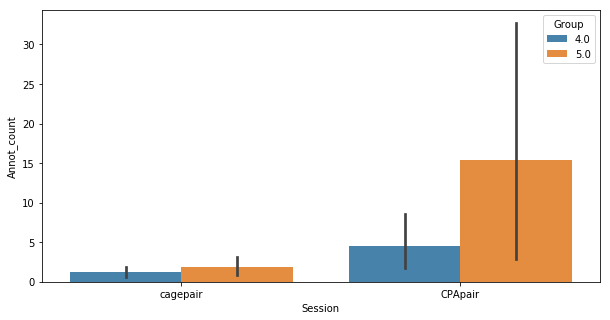

In [30]:
plt.figure(figsize=(10,5))
sns.barplot(x = 'Session', y = 'Annot_count', hue = 'Group', data = USV_complete, alpha=0.9)

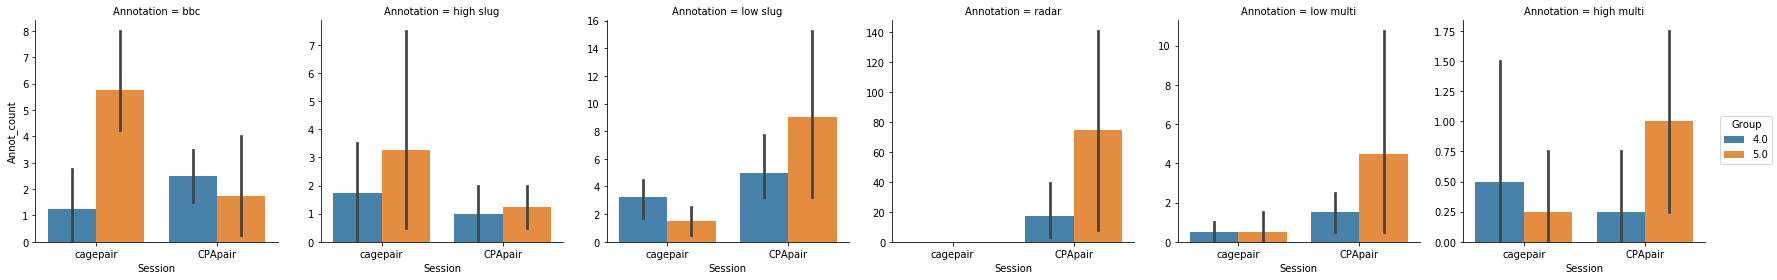

In [32]:
sns.factorplot(x = 'Session', y = 'Annot_count', hue = 'Group', col = 'Annotation', kind = 'bar', sharey = False, data = USV_complete, alpha=0.9)

Compute a response index ((resp_pair - resp_base) / (resp_pair + resp_base)) for each animal/USV param

In [ ]:
def ratio_calc(base, neutral, CPA, animal, annot_names):
    ratio_dic = {}
    for name in annot_names:
        ratio = []
        if len(CPA) == 0:
            try:
                ratio = float((neutral[neutral['Annotation'] == name]['Annot_count'].values - base[base['Annotation'] == name]['Annot_count'].values) / (neutral[neutral['Annotation'] == name]['Annot_count'].values + base[base['Annotation'] == name]['Annot_count'].values))
                ratio_dic[name] = ratio
            except ZeroDivisionError: 
                ratio = 0
                ratio_dic[name] = ratio
        else:
            try:
                ratio = float((CPA[CPA['Annotation'] == name]['Annot_count'].values - base[base['Annotation'] == name]['Annot_count'].values) / (CPA[CPA['Annotation'] == name]['Annot_count'].values + base[base['Annotation'] == name]['Annot_count'].values))
                ratio_dic[name] = ratio
            except ZeroDivisionError:
                ratio = 0
                ratio_dic[name] = ratio
    ratio_dic['Animal'] = int(animal)
    
    return ratio_dic

In [ ]:
ratio_df = pd.DataFrame(data = None, columns = annot_names)
for animal in animal_numbers:
    base, neutral, CPA = add_annot_rows(session_count, animal, annot_names)
    ratio_dic = ratio_calc(base, neutral, CPA, animal, annot_names)
    ratio_df = ratio_df.append(ratio_dic, ignore_index=True)
    
ratio_df.head()

In [ ]:
ratio_df = pd.merge(df_mice, ratio_df, on='Animal')
ratio_df

In [ ]:
ratio_df.groupby(["Group", 'Pair']).mean()

In [ ]:
plt.figure(figsize=(25,20))
sns.barplot(x = 'Pair', y = 'radar', hue = 'Group', data = ratio_df, alpha=0.9)

In [33]:
writer = pd.ExcelWriter('USV_counts.xlsx', engine='xlsxwriter')
USV_complete.to_excel(writer, sheet_name='Sheet1')
writer.save()